# ALS (Alternating Least Squares) for recommendations

Load Last.fm datasets and build a simple ALS-based recommender.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use("dark_background")

# Data paths (project root = parent of notebooks/)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_1K = PROJECT_ROOT / "data" / "lastfm-dataset-1K"
DATA_360K = PROJECT_ROOT / "data" / "lastfm-dataset-360K"

In [2]:
use_nrows = False

In [3]:
def user_checks(users):
    print(users.describe())
    print(users.info())
    users.age.replace("<NA>", -1, inplace=True)
    users.age.head(20).plot.hist(bins=20)
    plt.show()
    users.gender.value_counts().plot.bar()
    plt.show()
    users.country.value_counts().head(10).plot.bar()
    plt.show()
    countrie = users.country.value_counts()
    countrie = countrie[countrie>10]
    countrie.plot.bar()
    plt.show()

def artist_checks(plays):
    print(plays.describe())
    print(plays.info())
    print(plays.artist_name.nunique())
    artist_name_counts = plays.artist_name.value_counts()
    print(len(artist_name_counts))
    print(len(artist_name_counts[artist_name_counts > 10]))
    print(plays.artist_name.value_counts().mean())
    plays.groupby("artist_name").plays.sum().plot.hist(bins=20)
    plt.title("Artist Play Counts")
    plt.xlabel("Play Count")
    plt.ylabel("Number of Artists")
    plt.show()
    plays.groupby("user_id").plays.sum().plot.hist(bins=20)
    plt.title("User Play Counts")
    plt.xlabel("Play Count")
    plt.ylabel("Number of Users")
    plt.show()

    # Histogram: number of unique artists each user plays
    unique_artists_per_user = plays.groupby("user_id")["artist_id"].nunique()
    unique_artists_per_user.plot.hist(bins=20)
    plt.title("Unique Artists Per User")
    plt.xlabel("Number of Unique Artists Played")
    plt.ylabel("Number of Users")
    plt.show()

    # Histogram: log of number of unique listeners for each artist
    unique_users_per_artist = plays.groupby("artist_id")["user_id"].nunique()
    np.log1p(unique_users_per_artist).plot.hist(bins=20)
    plt.title("Log(Number of Unique Listeners) Per Artist")
    plt.xlabel("Log(Number of Unique Listeners + 1)")
    plt.ylabel("Number of Artists")
    plt.show()

## Last.fm 1K dataset

- **Profiles**: user id, gender, age, country, signup.
- **Interactions**: userid, timestamp, artist-id, artist-name, track-id, track-name (one row per play; file is very large).

In [4]:
# 1K user profiles (small, load fully)
users_1k = pd.read_csv(
    DATA_1K / "userid-profile.tsv",
    sep="\t",
    dtype={"#id": str, "gender": str, "age": "Int64", "country": str, "registered": str},
)
users_1k.rename(columns={"#id": "user_id"}, inplace=True)
users_1k

,user_id,gender,age,country,registered
0,user_000001,m,<NA>,Japan,"Aug 13, 2006"
1,user_000002,f,<NA>,Peru,"Feb 24, 2006"
2,user_000003,m,22,United States,"Oct 30, 2005"
3,user_000004,f,<NA>,NaN,"Apr 26, 2006"
4,user_000005,m,<NA>,Bulgaria,"Jun 29, 2006"
...,...,...,...,...,...
987,user_000996,f,<NA>,United States,"Jul 17, 2006"
988,user_000997,m,<NA>,United States,"Jan 5, 2007"
989,user_000998,m,<NA>,United Kingdom,"Sep 28, 2005"
990,user_000999,f,<NA>,Poland,"Jul 24, 2007"


             age
count      286.0
mean   25.367133
std     8.314952
min          3.0
25%         21.0
50%         23.0
75%         28.0
max        103.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     992 non-null    object
 1   gender      884 non-null    object
 2   age         286 non-null    Int64 
 3   country     907 non-null    object
 4   registered  984 non-null    object
dtypes: Int64(1), object(4)
memory usage: 39.8+ KB
None


C:\Users\Fern_PC II\AppData\Local\Temp\ipykernel_20088\3923181185.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users.age.replace("<NA>", -1, inplace=True)


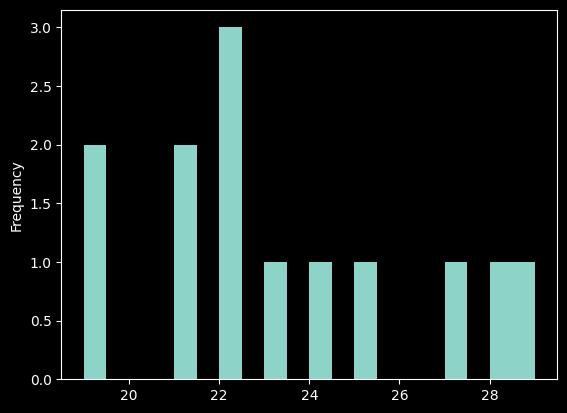

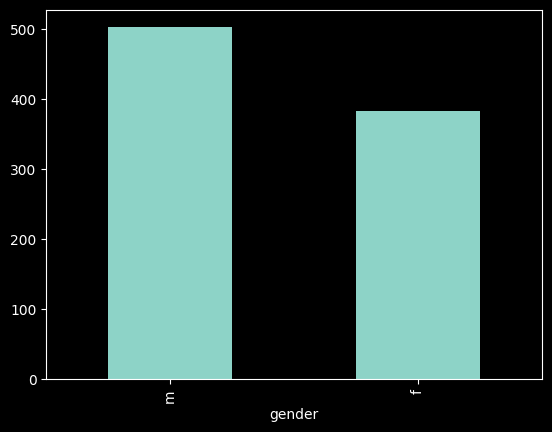

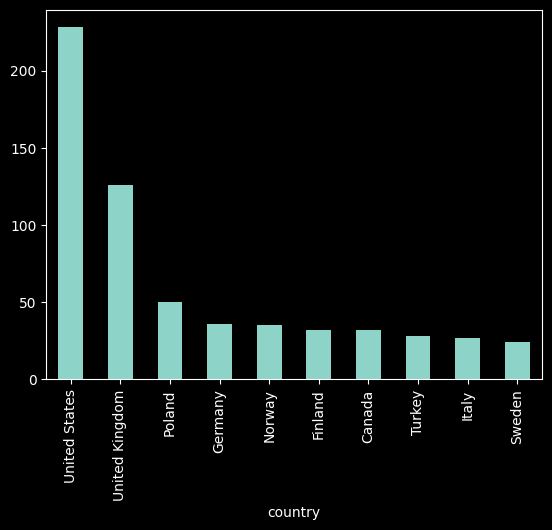

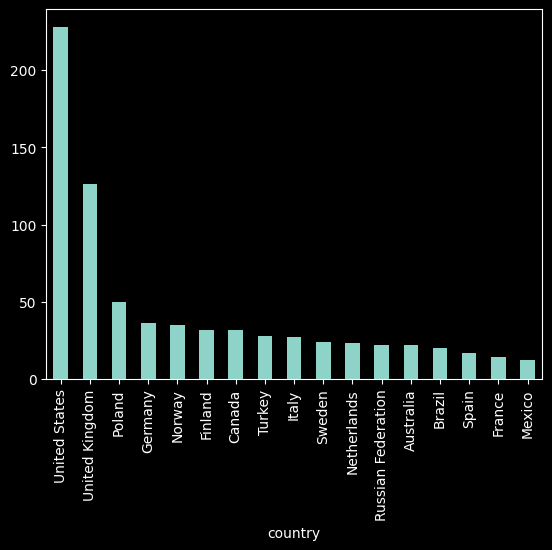

In [5]:
user_checks(users_1k)

In [6]:
# 1K interactions: one row per play (~19M rows, ~2.5GB). Load a sample for development.
# Omit timestamp/track columns to save memory; use more rows or full file as needed.
plays_1k = pd.read_csv(
    DATA_1K / "userid-timestamp-artid-artname-traid-traname.tsv",
    sep="\t",
    header=None,
    names=["user_id", "timestamp", "artist_id", "artist_name", "track_id", "track_name"],
    usecols=["user_id", "artist_id", "artist_name"],
    dtype={"user_id": str, "artist_id": str, "artist_name": str},
    nrows=500_000 if use_nrows else None,
)
# Aggregate to user–artist play counts (for ALS we need user, item, strength)
plays_1k = plays_1k.groupby(["user_id", "artist_id", "artist_name"], as_index=False).size().rename(columns={"size": "plays"})
plays_1k

,user_id,artist_id,artist_name,plays
0,user_000001,00c73a38-a449-4990-86ca-5088dde1b8df,Dj Rels,2
1,user_000001,012a77c9-c897-494f-87d0-0a730996494d,Vincent,1
2,user_000001,014ba96b-b8da-49e3-8a2b-b720ae42e84c,Dbx,3
3,user_000001,01ce7548-dab4-4ca6-8dfc-8e2e4b50d461,Lars Bartkuhn,4
4,user_000001,03282c56-8a24-42f4-8bfc-96188933aefa,Angela Bofill,4
...,...,...,...,...
819780,user_001000,ff3e120c-c929-4ad4-bbbd-04d1689ffc54,Gifts From Enola,1
819781,user_001000,ff6e677f-91dd-4986-a174-8db0474b1799,Jack Johnson,42
819782,user_001000,ff9deaae-da4f-42b7-a19e-36fedd3fc706,Ben Kweller,2
819783,user_001000,ffb18e19-64a4-4a65-b4ce-979e00c3c69d,The Album Leaf,137


               plays
count  819785.000000
mean       22.564464
std       122.958287
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max     26496.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819785 entries, 0 to 819784
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      819785 non-null  object
 1   artist_id    819785 non-null  object
 2   artist_name  819785 non-null  object
 3   plays        819785 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 25.0+ MB
None
104511
104511
12717
7.844006850953488


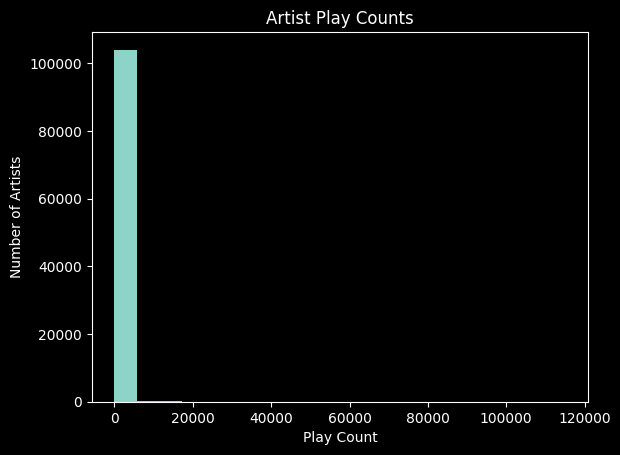

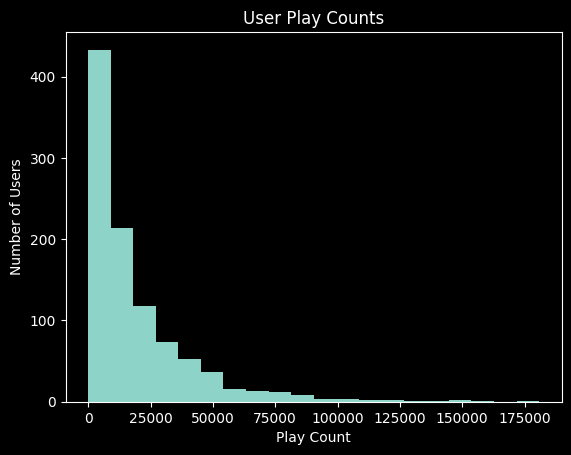

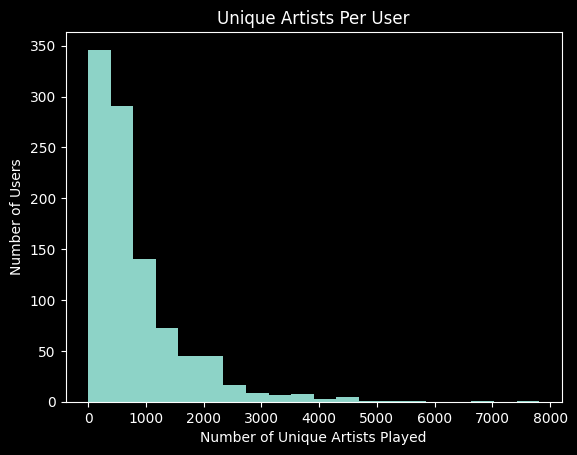

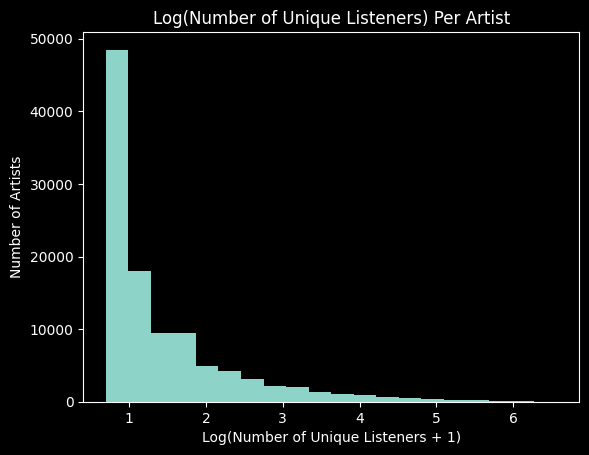

In [7]:
artist_checks(plays_1k)

## Last.fm 360K dataset

- **Profiles**: user (sha1), gender, age, country, signup.
- **Interactions**: user, artist-mbid, artist-name, **plays** (already aggregated; good for ALS).

In [8]:
# 360K user profiles (no header in file)
users_360k = pd.read_csv(
    DATA_360K / "usersha1-profile.tsv",
    sep="\t",
    header=None,
    names=["user_id", "gender", "age", "country", "registered"],
    dtype={"user_id": str, "gender": str, "age": "Int64", "country": str, "registered": str},
)
users_360k

,user_id,gender,age,country,registered
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,<NA>,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,<NA>,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28,United States,"Jan 27, 2006"
...,...,...,...,...,...
359342,fffe7823f67b433b45f22056467db921c1d3d7d0,m,25,Germany,"Jun 24, 2006"
359343,fffe8637bd8234309e871409c7ebef99a720afc1,m,25,Brazil,"Sep 9, 2007"
359344,fffe8c7f952d9b960a56ed4dcb40a415d924b224,m,20,United States,"Aug 8, 2007"
359345,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,m,20,Russian Federation,"Dec 3, 2005"


             age
count   284447.0
mean   25.098046
std    21.665742
min      -1337.0
25%         20.0
50%         23.0
75%         28.0
max       1002.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359347 entries, 0 to 359346
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     359347 non-null  object
 1   gender      326572 non-null  object
 2   age         284447 non-null  Int64 
 3   country     359347 non-null  object
 4   registered  359347 non-null  object
dtypes: Int64(1), object(4)
memory usage: 14.1+ MB
None


C:\Users\Fern_PC II\AppData\Local\Temp\ipykernel_20088\3923181185.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users.age.replace("<NA>", -1, inplace=True)


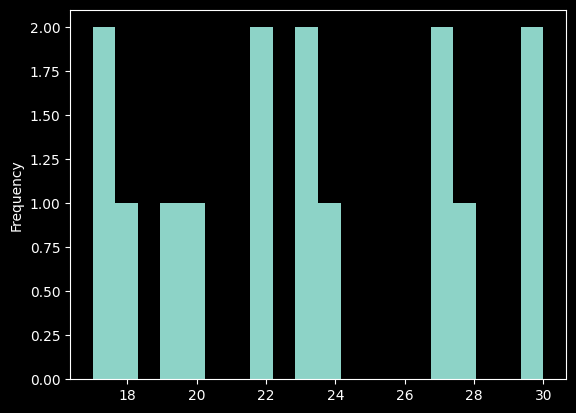

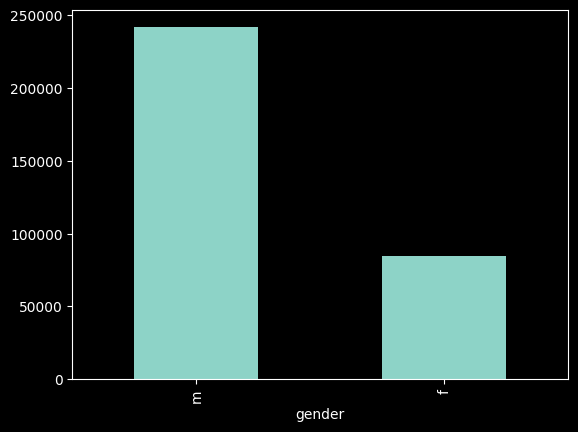

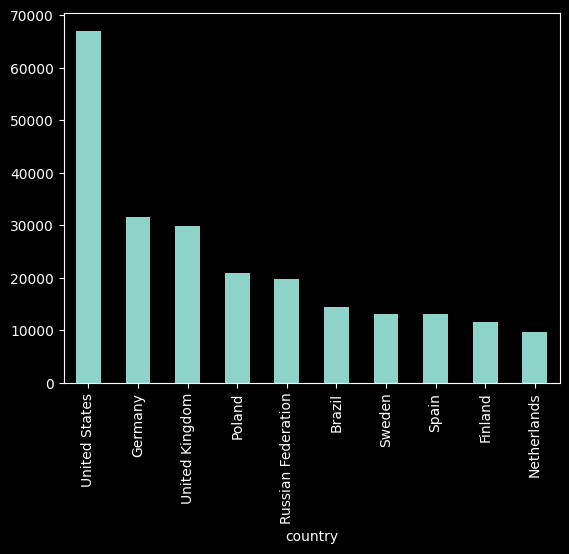

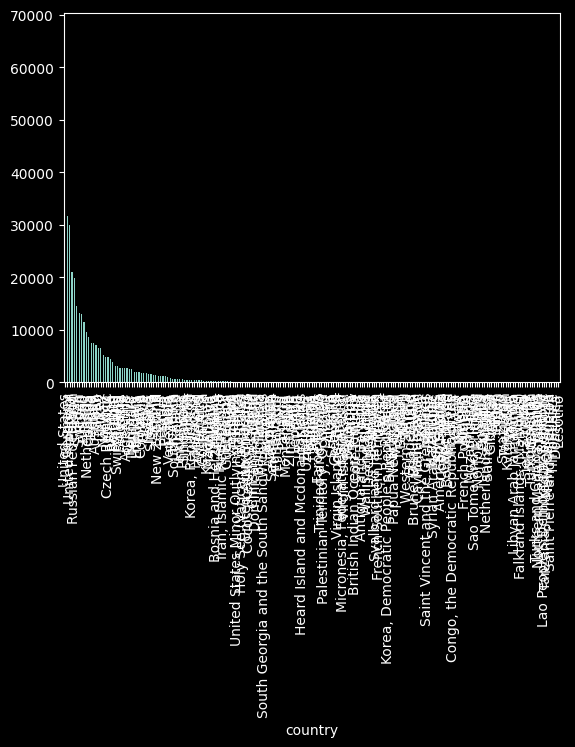

In [9]:
user_checks(users_360k)

In [10]:
# 360K user–artist plays (already aggregated). Full file ~17.5M rows; use nrows for quick runs.
plays_360k = pd.read_csv(
    DATA_360K / "usersha1-artmbid-artname-plays.tsv",
    sep="\t",
    header=None,
    names=["user_id", "artist_id", "artist_name", "plays"],
    dtype={"user_id": str, "artist_id": str, "artist_name": str, "plays": np.int32},
    nrows=500_000 if use_nrows else None,
)
plays_360k

,user_id,artist_id,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...,...
17535650,"sep 20, 2008",7ffd711a-b34d-4739-8aab-25e045c246da,turbostaat,12
17535651,"sep 20, 2008",9201190d-409f-426b-9339-9bd7492443e2,cuba missouri,11
17535652,"sep 20, 2008",e7cf7ff9-ed2f-4315-aca8-bcbd3b2bfa71,little man tate,11
17535653,"sep 20, 2008",f6f2326f-6b25-4170-b89d-e235b25508e8,sigur rós,10


              plays
count  1.753566e+07
mean   2.151932e+02
std    6.144815e+02
min    0.000000e+00
25%    3.500000e+01
50%    9.400000e+01
75%    2.240000e+02
max    4.191570e+05
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17535655 entries, 0 to 17535654
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   artist_id    object
 2   artist_name  object
 3   plays        int32 
dtypes: int32(1), object(3)
memory usage: 468.3+ MB
None
292363
292363
64337
59.978352253876174


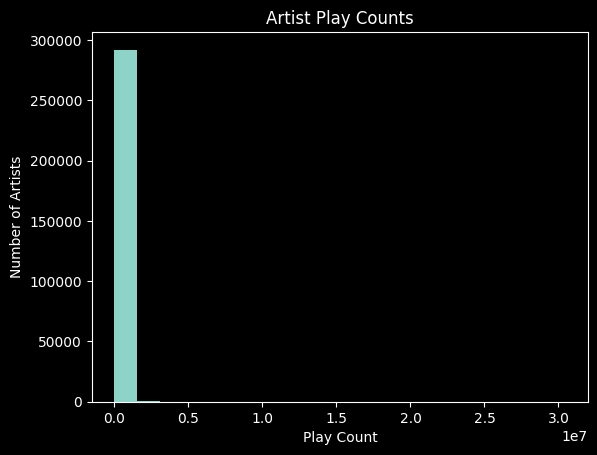

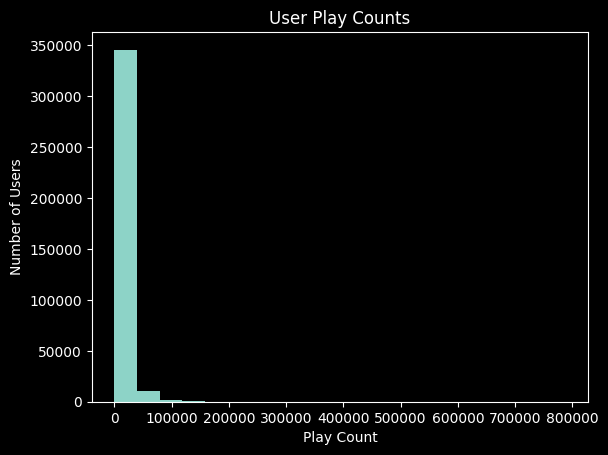

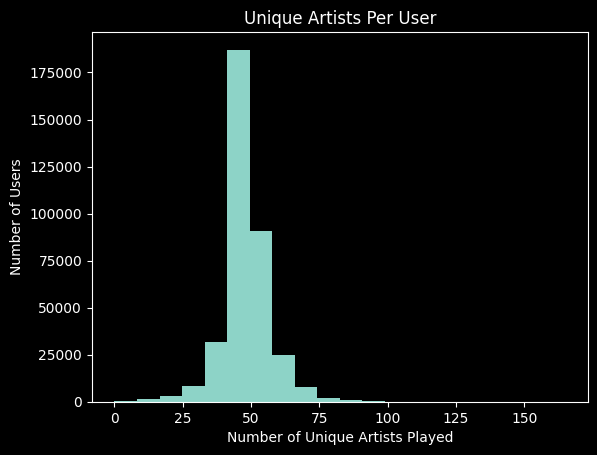

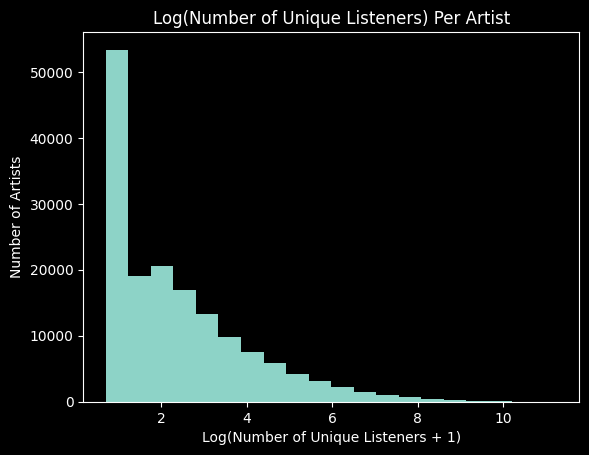

In [11]:
artist_checks(plays_360k)

# Conclusions

360k dataset seems more interesting for a recommendation problem: more users listening to lots of artists lets us do some more fun stuff. 1k dataset seems a bit too sparse.  